In [16]:
import sys
sys.path.append('../')
import random
from cyto_ml.data.vectorstore import vector_store
from skimage import io
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

By now we should have a vector db (chromadb for now, sqlite3 under the hood) full of 2048-long lists of image embeddings.
What can we hope to drop out of them?

* Image similarity search (either on an image in this collection, or an unseen one)
* Different self-supervised clustering methods (nice reference here: https://sslneurips23.github.io/paper_pdfs/paper_70.pdf)

What are the outcomes we are looking for here (if any of this in fact works?)

* Insights into assemblies of functional traits without having to do much taxonomy, very open-ended
* Ability to train a cheap-to-run binary classifier (plankton or not) that reliably filters data before it goes into object storage, without having to develop many rules
* Ability to gauge how well an off the shelf model is able to discriminate our data (assess the value of doing a lot of labelling for a custom model)
* Utility for assisted labelling without having to do _much_ ML (e.g. similarity search to autosuggest attributes based on colocated clusters)


In [8]:
store = vector_store('plankton')
store.count()


INFO:root:Collection plankton already exists


8805

See what we can get out of the box with Chroma 
https://github.com/neo-con/chromadb-tutorial/tree/main/4.%20Querying%20a%20Collection/1.%20Querying%20Embeddings


Without parameters, this gives us back all the document identifiers (if you want the document - in our case the same URL as the ID - or the embeddings, you have to ask `get` for that with an `include=['field','names']`)

In [9]:
res = store.get()


In [10]:
test_image_url = random.choice(res['ids'])
test_embed = store.get([test_image_url],include=['embeddings'])['embeddings']


Query for the 24 closest image matches (plus the image itself which comes back with a distance of 0)

In [23]:
results = store.query(
    query_embeddings=test_embed,
    n_results=25
)

Note that here we're looking at `results['ids'][0]` because `chromadb` will always assume we queried for a list.
Plot the closest matches labelled with their distance from the original.

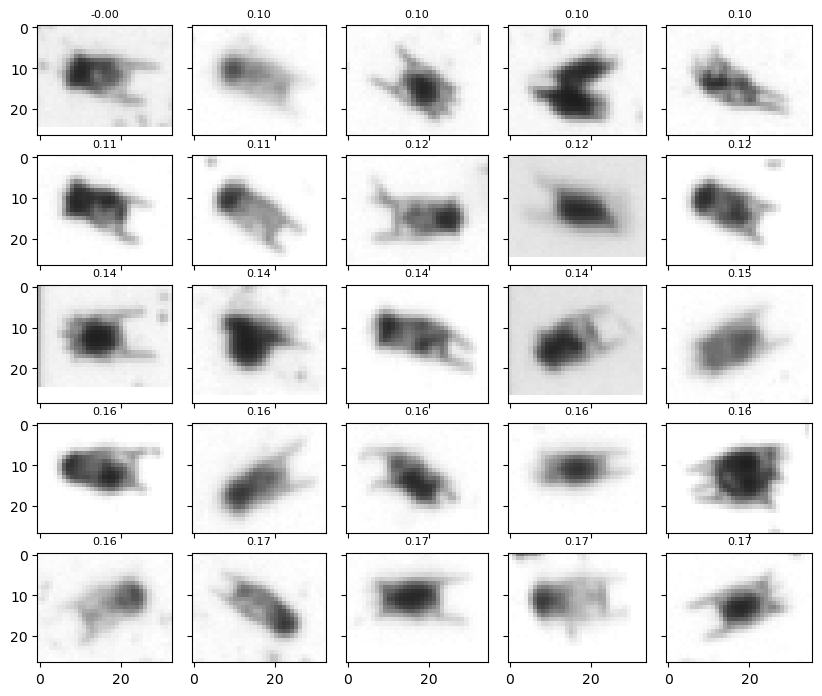

In [34]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),  # creates 2x2 grid of axes
                 axes_pad=0.2,  # pad between axes in inch.
                 )

for index, ax in enumerate(grid):
    # Iterating over the grid returns the Axes.
    ax.imshow(io.imread(results['ids'][0][index]))
    dist = results['distances'][0][index]
    ax.set_title(f'{dist:.2f}', fontsize=8)